In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow.compat.v1 as tf
#import tensorflow as tf
import tensorflow_hub as hub
#tf.enable_eager_execution()
tf.disable_v2_behavior()

elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
SEQ_LEN = 150

In [ ]:
df = pd.read_csv('processed_data.csv')
df = df.sample(frac = 1)

In [ ]:
anot = {}
for ele in df['Annotation']:
  if ele in anot:
    anot[ele]+=1
  else:
    anot[ele] = 1
anot

{'S': 182, 'N': 568, 'U': 132}

In [ ]:
print(len(df))
df = df.dropna()
print(len(df))

882
882


In [ ]:
arr = df['Annotation'].values
print(type(arr))
def switch(row):
    dic = {
        'S':0,
        'N':1,
        'U':2
    }
    return dic.get(row)

arr = np.array([switch(x) for x in arr])
print(np.unique(arr))
labels = np.zeros((arr.size,len(np.unique(arr))))
arr

<class 'numpy.ndarray'>
[0 1 2]


array([0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2,
       0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1,
       0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2,
       1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1,
       0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1,
       1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2,

In [ ]:
labels[np.arange(arr.size),arr] = 1
labels[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
input_tensor = df['PlainText'].tolist()


embeddings = elmo(input_tensor,signature="default",as_dict=True)["elmo"]

print(embeddings.shape)
print(embeddings)

(882, 228, 1024)
Tensor("module_apply_default/aggregation/mul_3:0", shape=(882, 228, 1024), dtype=float32)


In [ ]:
from sklearn.model_selection import train_test_split

texts=input_tensor
texts = [' '.join(t.split()[:SEQ_LEN]) for t in texts]
texts = np.array(texts, dtype=object)[:, np.newaxis]

x_train, x_val, y_train, y_val = train_test_split(texts, labels, random_state=1992, test_size=0.2)

In [ ]:
from tensorflow.python.keras import backend as K

class ElmoEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def __repr__(self):
        return "trying"
        
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/3', trainable=self.trainable,
                               name="{}_module".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(
            K.squeeze(K.cast(x, tf.string), axis=1),
            as_dict=True,
            signature='default',
            )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [ ]:
# input_text = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
# embedding = ElmoEmbeddingLayer()(input_text)
# x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# x = tf.keras.layers.BatchNormalization()(x)
input_text = tf.keras.Input(shape=(1,), dtype="string", name='input_0')
x = ElmoEmbeddingLayer(name = "embed")(input_text)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)
y = tf.keras.layers.Dense(3,activation='softmax',name='outputs')(x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model = tf.keras.Model(inputs=[input_text], outputs=y)

In [ ]:
model.layers

 trying,

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, 1)]               0         
                                                                 
 embed (ElmoEmbeddingLayer)  (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 16)                1040  

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer = optimizer,loss = loss,metrics = [acc])

Train on 705 samples, validate on 177 samples
Epoch 1/40
705/705 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.5702

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


705/705 [==============================] - 10s 14ms/sample - loss: 0.9855 - accuracy: 0.5702 - val_loss: 0.8745 - val_accuracy: 0.6780
Epoch 2/40
705/705 [==============================] - 9s 12ms/sample - loss: 0.9108 - accuracy: 0.6340 - val_loss: 0.8333 - val_accuracy: 0.6780
Epoch 3/40
705/705 [==============================] - 12s 17ms/sample - loss: 0.8752 - accuracy: 0.6355 - val_loss: 0.8097 - val_accuracy: 0.6780
Epoch 4/40
705/705 [==============================] - 9s 13ms/sample - loss: 0.8722 - accuracy: 0.6355 - val_loss: 0.8024 - val_accuracy: 0.6780
Epoch 5/40
705/705 [==============================] - 9s 12ms/sample - loss: 0.8368 - accuracy: 0.6355 - val_loss: 0.7852 - val_accuracy: 0.6780
Epoch 6/40
705/705 [==============================] - 9s 12ms/sample - loss: 0.8144 - accuracy: 0.6369 - val_loss: 0.7691 - val_accuracy: 0.6780
Epoch 7/40
705/705 [==============================] - 9s 13ms/sample - loss: 0.8124 - accuracy: 0.6369 - val_loss: 0.7675 - val_accuracy: 0

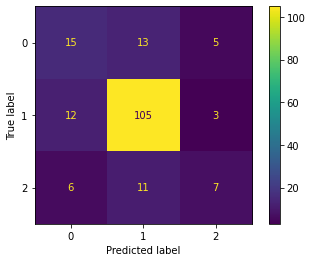

In [ ]:
with tf.compat.v1.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  history = model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs = 40, class_weight={0:1,1:1,2:1})

  y_test = []
  y_pred = []

  for ele in x_val:
      x = model.predict(ele)
      y = np.argmax(x)
      y_pred.append(y)
          
  for x in y_val:
      y = np.argmax(x)
      y_test.append(y)
      
  predictions = y_pred

  from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  cm = confusion_matrix(y_test, predictions, labels=[0,1,2])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
  acc_score = accuracy_score(y_test,predictions)
  pre_score = precision_score(y_test,predictions,average='micro')
  rec_score = recall_score(y_test,predictions,average='micro')
  print('Accuracy_score: ',acc_score)
  print('Precision_score: ',pre_score)
  print('Recall_score: ',rec_score)
  print("-"*50)
  cr = classification_report(y_test,predictions)
  print(cr)
  disp.plot()